<a href="https://colab.research.google.com/github/jhoynoski/House_Pricing_Regressions/blob/main/House_Price_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook predicts housing prices using various regression models on the Boston Housing dataset. Steps include data cleaning, outlier handling, preprocessing, model training, evaluation, and comparison. Over 10 models are compared based on R², MAE, and cross-validation with visualized final results  to identify top-performing algorithms.

#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
try:
    import google.colab
    !pip install wget
except ImportError:
    pass

import wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e0b45d76d9e3eccd494c9094044a456df869c53040818599eb97528df3f1226c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


Downloading the dataset from a url using wget as a dataframe and getting basic descriptors such as count, mean, and distribution.

In [ ]:
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'
filename = wget.download(url)

df = pd.read_csv(filename)
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Looking to see if there are any null or duplicate datapoints in the dataset.

In [ ]:
print("Null values:", df.isnull().sum().sum())
print("Duplicate values:", df.duplicated().sum())

Null values: 0
Duplicate values: 0


After null and duplicate data has been addressed, now we'll work on outliers. Outliers are being defined as data points that are below 25% or above 75% of the median of that column. Data points that meet that criteria will be replaced with the median. The output will be saved as a new dataset.

In [ ]:
pd.options.mode.copy_on_write = True

def replace_outliers_with_median(df):
    for column in df.select_dtypes(include=['number']).columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        median = df[column].median()
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
    return df

data_cleaned = replace_outliers_with_median(df.copy())
data_cleaned.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.0,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,1.075493,2.763834,11.136779,0.0,0.554695,6.231747,68.574901,3.718598,9.549407,408.237154,18.637253,389.121798,12.326996,20.757115
std,2.009455,7.357024,6.860353,0.0,0.115878,0.517519,28.148861,1.980432,8.707259,168.537116,1.937389,10.340151,6.632190,6.192007
min,0.006320,0.000000,0.460000,0.0,0.385000,4.880000,2.900000,1.129600,1.000000,187.000000,13.600000,344.910000,1.730000,5.600000
25%,0.082045,0.000000,5.190000,0.0,0.449000,5.899750,45.025000,2.100175,4.000000,279.000000,17.400000,388.115000,6.950000,17.100000
50%,0.255190,0.000000,9.690000,0.0,0.538000,6.208500,77.500000,3.203325,5.000000,330.000000,19.075000,391.445000,11.350000,21.200000
75%,0.635910,0.000000,18.100000,0.0,0.624000,6.515250,94.075000,5.112625,24.000000,666.000000,20.200000,396.225000,16.462500,23.800000
max,8.982960,30.000000,27.740000,0.0,0.871000,7.691000,100.000000,9.222900,24.000000,711.000000,22.000000,396.900000,30.810000,36.500000


The *zn* and *chas* columns do not have much variation within them with the vast majority of the data being zeros. So we'll just drop them.

In [ ]:
data_cleaned = data_cleaned.drop(columns=['zn', 'chas'], inplace=True)
data_cleaned.describe()

,crim,indus,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,1.075493,11.136779,0.554695,6.231747,68.574901,3.718598,9.549407,408.237154,18.637253,389.121798,12.326996,20.757115
std,2.009455,6.860353,0.115878,0.517519,28.148861,1.980432,8.707259,168.537116,1.937389,10.340151,6.632190,6.192007
min,0.006320,0.460000,0.385000,4.880000,2.900000,1.129600,1.000000,187.000000,13.600000,344.910000,1.730000,5.600000
25%,0.082045,5.190000,0.449000,5.899750,45.025000,2.100175,4.000000,279.000000,17.400000,388.115000,6.950000,17.100000
50%,0.255190,9.690000,0.538000,6.208500,77.500000,3.203325,5.000000,330.000000,19.075000,391.445000,11.350000,21.200000
75%,0.635910,18.100000,0.624000,6.515250,94.075000,5.112625,24.000000,666.000000,20.200000,396.225000,16.462500,23.800000
max,8.982960,27.740000,0.871000,7.691000,100.000000,9.222900,24.000000,711.000000,22.000000,396.900000,30.810000,36.500000


This is what the new data distributions look like without outliers or the *zn* and *chas* data columns. The returned array from the hist function has been suppressed since the columns of the dataframe are known.

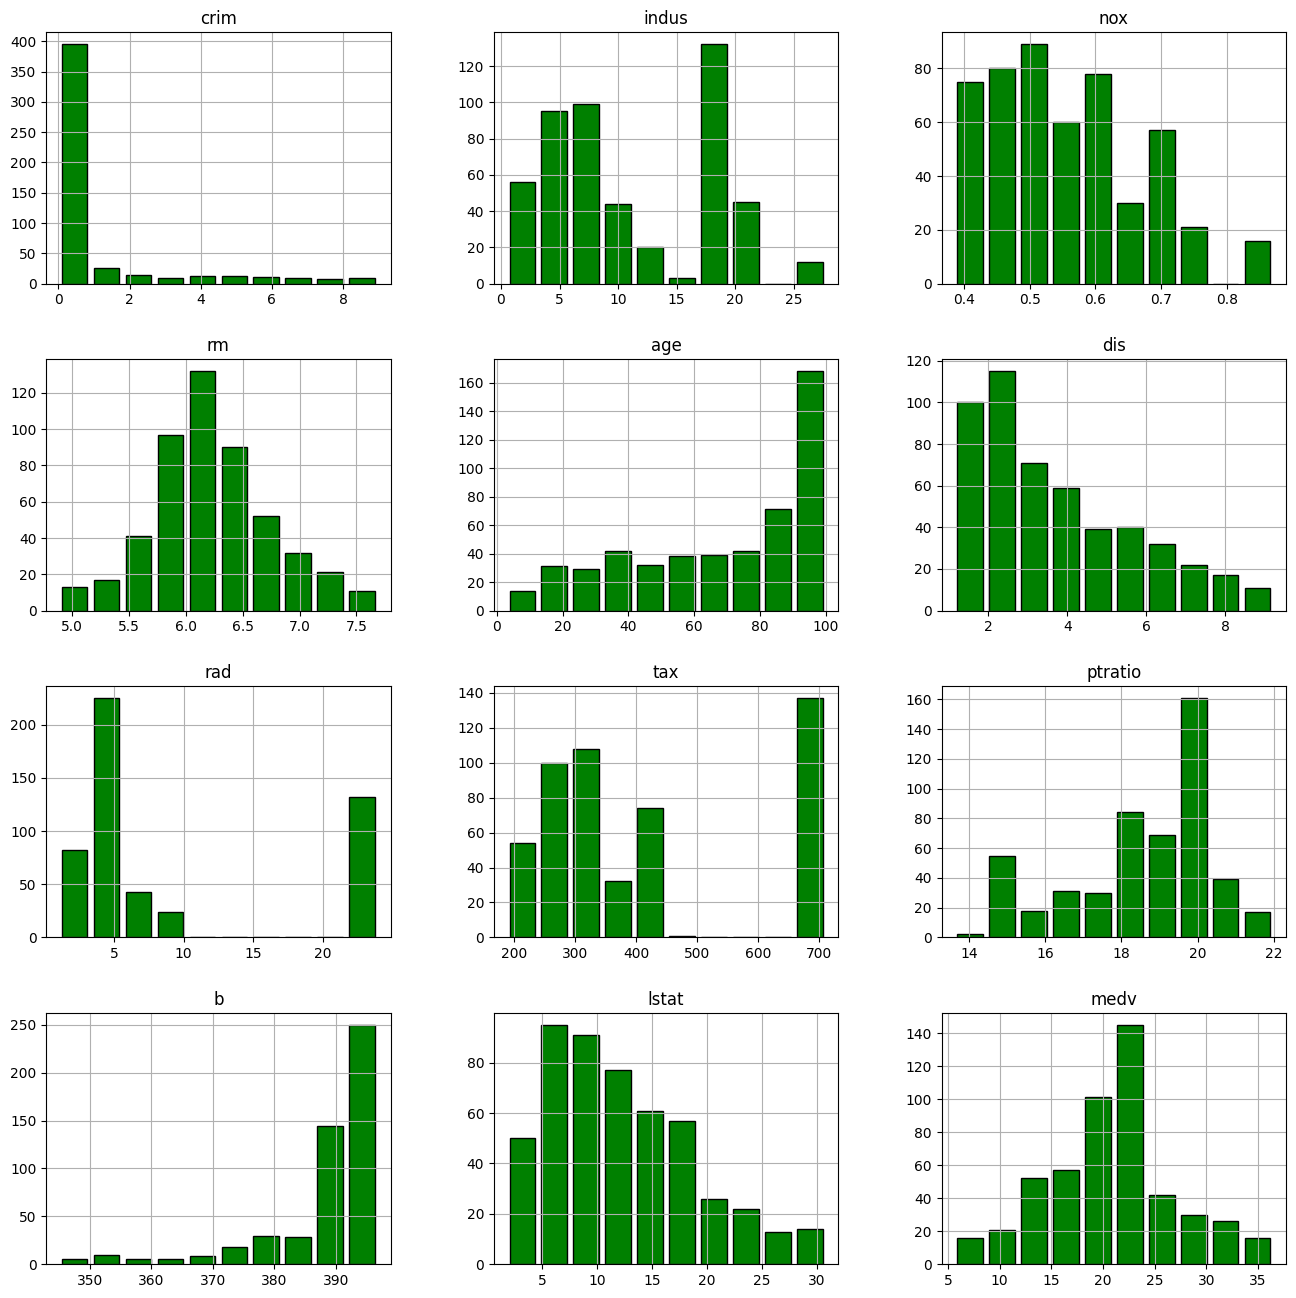

In [ ]:
data_cleaned.hist(figsize=(16,16),edgecolor='black', rwidth=0.8, color='green');

#Data Modeling

Splitting the dataset into 4 sections: X_train, X_test, y_train, y_test.

In [ ]:
X = data_cleaned.drop('medv', axis=1)
y = data_cleaned['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creating two lists. The first list is of classifier names to be used, and the second of the classifiers themselves.

In [ ]:
names = ["KNN", "Linear SVR", "Decision Tree", "Random Forest", "Neural Net",
         "Linear Regression", "Ridge", "Lasso", "AdaBoost", "Gradient Boost", "XGBRF"]

classifiers = [KNeighborsRegressor(),
               LinearSVR(C=2, epsilon=3, fit_intercept=True, loss='epsilon_insensitive'),
               DecisionTreeRegressor(criterion='poisson', max_depth=4, max_features='log2', splitter='best'),
               RandomForestRegressor(criterion='poisson', max_depth=10, max_features='log2'),
               MLPRegressor(activation='tanh', hidden_layer_sizes=(14,), solver='sgd'),
               LinearRegression(),
               Ridge(random_state=42),
               Lasso(alpha=0.25, max_iter=100),
               AdaBoostRegressor(loss='exponential', n_estimators=15),
               GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.25, loss='huber', n_estimators=150),
               xgb.XGBRFRegressor()]

Initialize the figure and metrics lists for r² score, mean absolute error, mean standard error, and cross validation score. Then run a loop that will scale, run the classifiers, calculate performance metrics, and plot the results.

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum 

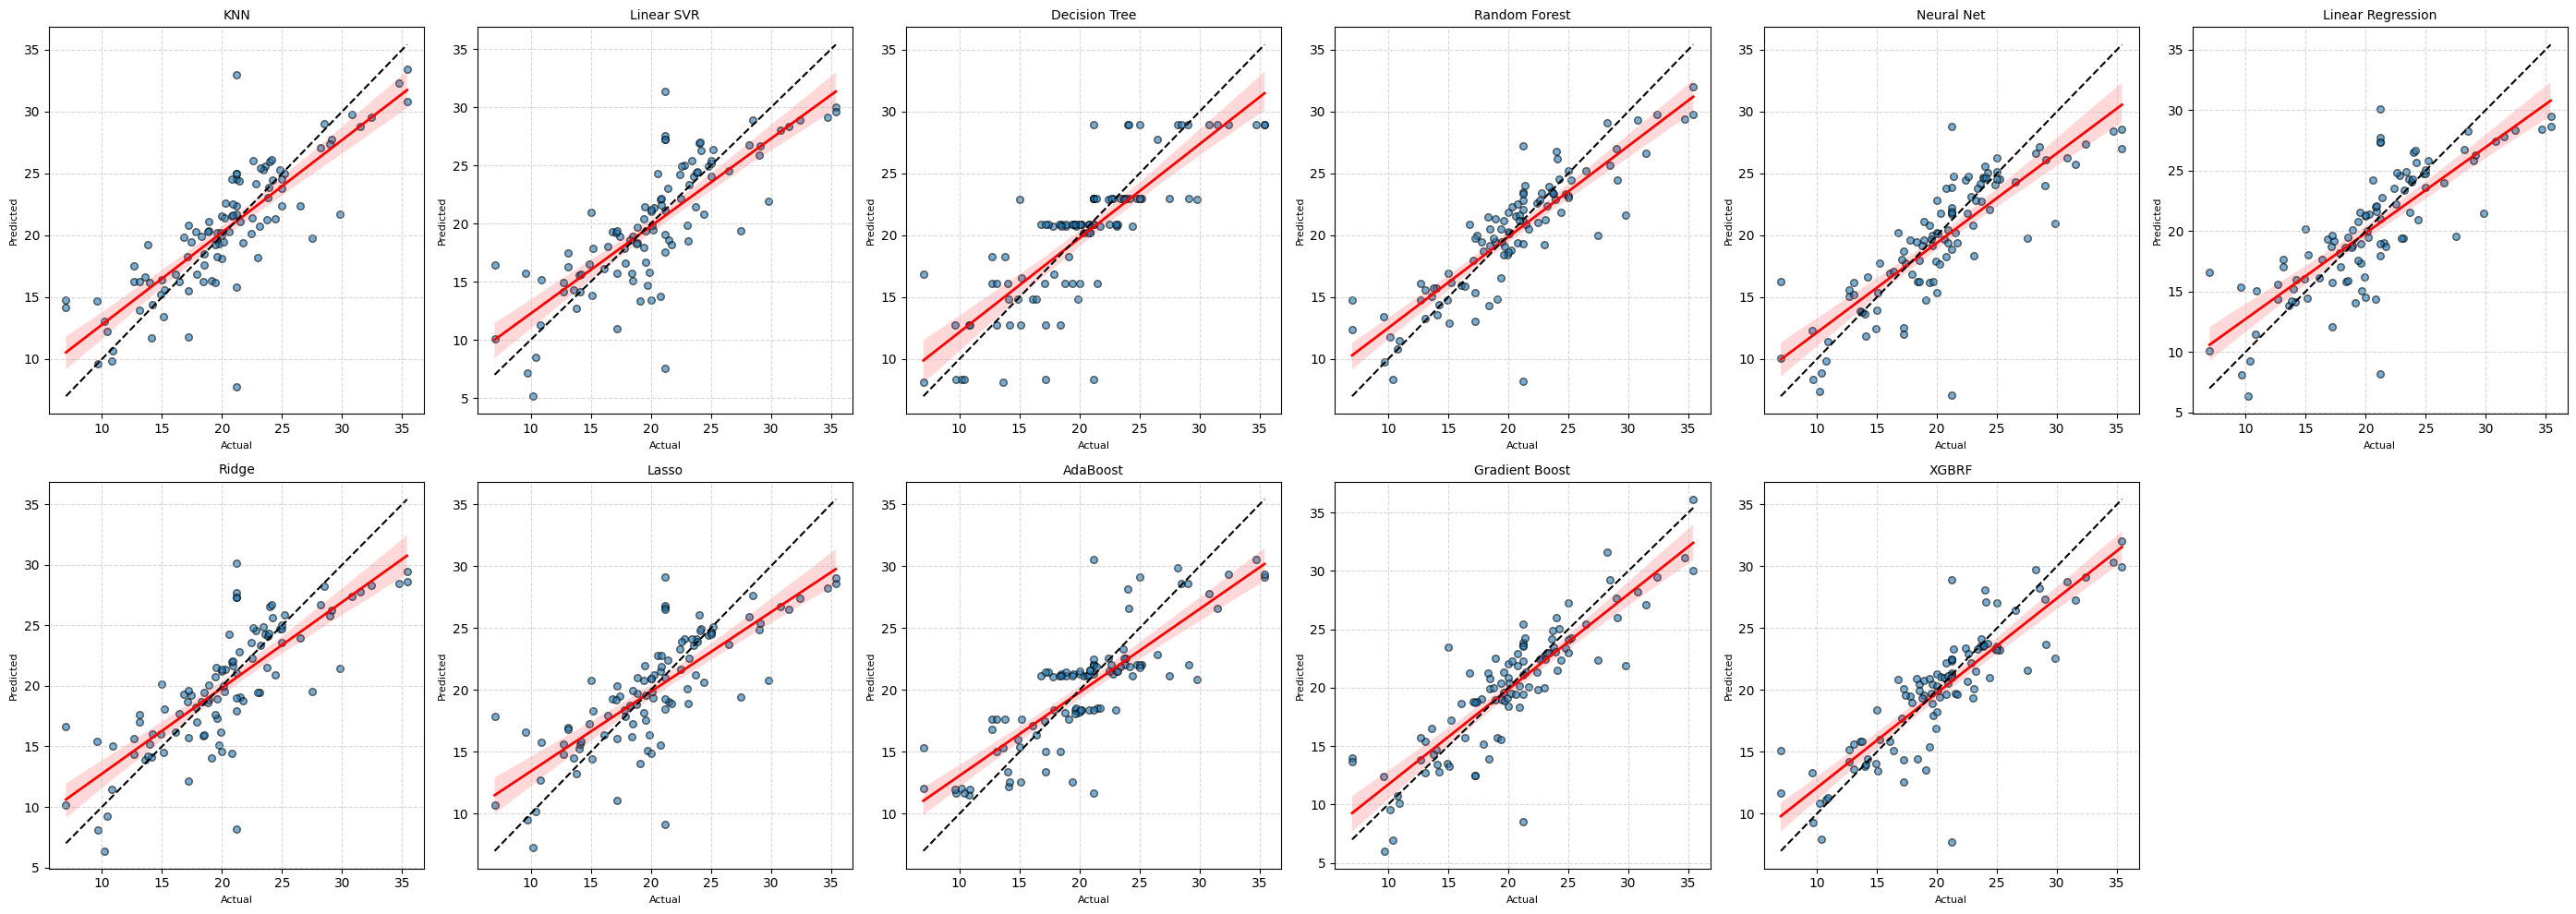

In [ ]:
# Evaluation storage
r2, mae, mse, cvs = [], [], [], []

# Visualization and metrics
plt.figure(figsize=(28, 10))

for i, (name, model) in enumerate(zip(names, classifiers), 1):
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Metrics
    r2.append(r2_score(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    mse.append(mean_squared_error(y_test, y_pred))
    cvs.append(cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean())

    # Plot Predictions
    ax = plt.subplot(2, 6, i)
    sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'black'},
                line_kws={'color': 'red', 'linewidth': 2})
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    ax.set_title(f"{name}", fontsize=10)
    ax.set_xlabel("Actual", fontsize=8)
    ax.set_ylabel("Predicted", fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

To create a results table, all of the performance metrics have been placed into a dataframe and sorted based on the r² score.

In [ ]:
results = pd.DataFrame({'Model': names, 'R² Score': r2, 'MAE': mae, 'MSE': mse, 'Cross Validation Score': cvs})

results.sort_values(by='R² Score', ascending=False, inplace=True)
results

,Model,R² Score,MAE,MSE,Cross Validation Score
3,Random Forest,0.753648,2.024521,8.248121,0.711763
10,XGBRF,0.744953,2.046158,8.539219,0.673292
9,Gradient Boost,0.741086,2.171278,8.668683,0.683120
0,KNN,0.683155,2.316667,10.608286,0.667466
8,AdaBoost,0.679347,2.550356,10.735778,0.622361
4,Neural Net,0.673587,2.327879,10.928625,0.658421
2,Decision Tree,0.643411,2.551699,11.938946,0.572099
5,Linear Regression,0.623412,2.613172,12.608542,0.602068
6,Ridge,0.623399,2.614467,12.608981,0.602387
7,Lasso,0.619111,2.614466,12.752526,0.601344


Finally, we create a bar graph to visualize the R² and cross validation scores performance metrics.

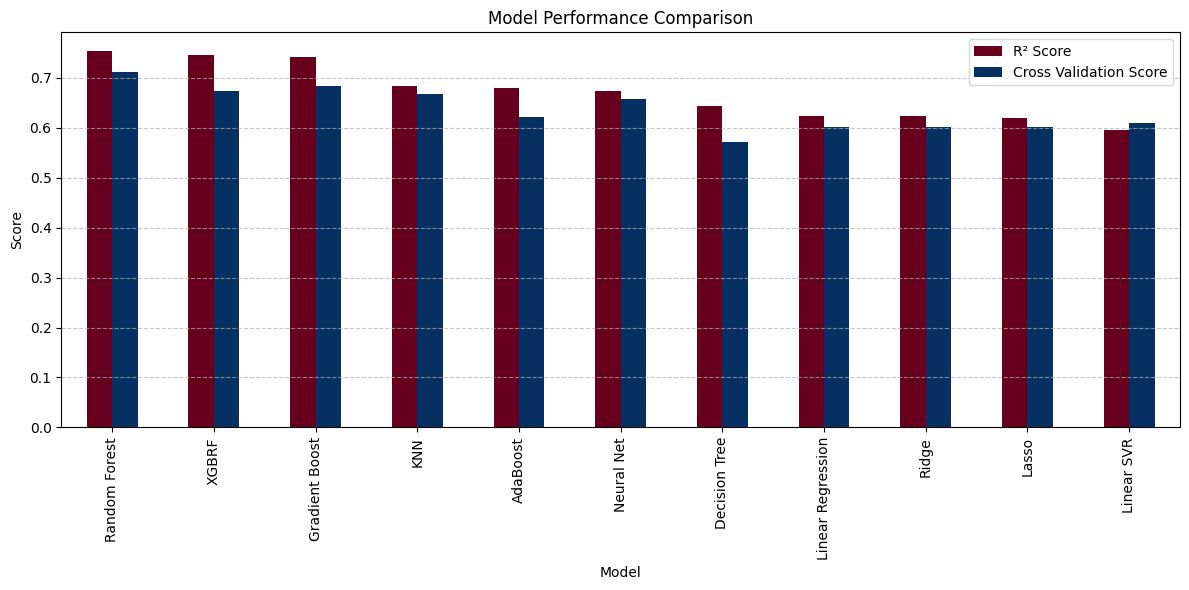

In [ ]:
results.set_index('Model')[['R² Score', 'Cross Validation Score']].plot(kind='bar', figsize=(12, 6), colormap='RdBu')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Overall, the random forest regressor was the best model for this dataset. There are a lot of variables in this particular dataset and some algorithms can handle many variables better than others. In the data plots you can see some models struggled with how to predict this dynamic data with the most visual examples of this being the decision tree regressor and AdaBoost with clear data clustering bands. Since the random forest regressor utilizes multiple decision trees to accomplish its task, it was able to handle the variety of variables in a more comprehensive way compared to the decision tree regressor and linear regression.